In [1]:
import cv2
import numpy as np

def process_image(original):
    processed = preprocess_image(original)
    corners = find_corners_of_largest_polygon(processed)
    _, underlying = cv2.threshold(original, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return crop_and_warp(underlying, corners)

def preprocess_image(img, skip_dilate=False, skip_invert=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernel size (height, width) of 9.
    # Note that kernel sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img, (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise it will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)

    # Dilate the image to increase the size of the grid lines.
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
    proc = cv2.dilate(proc, kernel)

    return proc
    
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    print(cv2.contourArea(contours[0]))

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right = np.array([pt[0][0] + pt[0][1] for pt in polygon]).argmax()
    top_left = np.array([pt[0][0] + pt[0][1] for pt in polygon]).argmin()
    bottom_left = np.array([pt[0][0] - pt[0][1] for pt in polygon]).argmin()
    top_right = np.array([pt[0][0] - pt[0][1] for pt in polygon]).argmax()

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return ((a ** 2) + (b ** 2))**(1/2)

def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular-like section from an image into a rectangular similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    width = max([
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    height = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
    ])

    # If the found rectangle is smaller than 30% of the image,
    # it is probably wrong and the image won't be cropped
    if width * height < 0.3 * img.shape[0] * img.shape[1]:
        return img

    # Describe a rectangle with calculated width and height, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the given image
    return cv2.warpPerspective(img, m, (int(width), int(height)))


1846.0


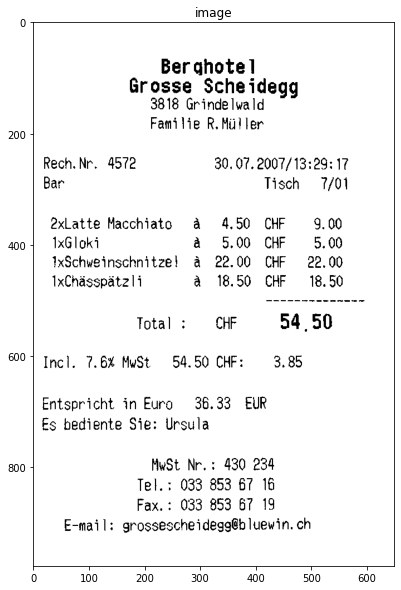

3930.0


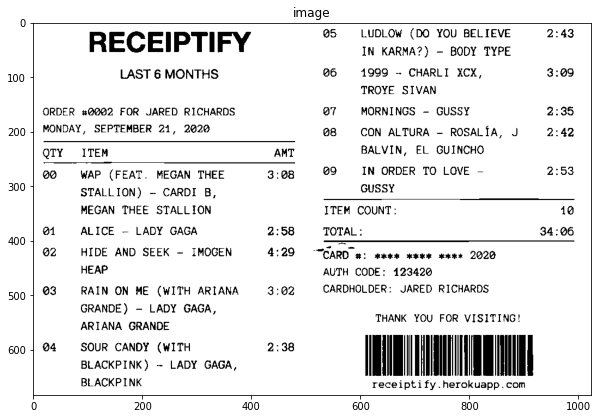

631769.5


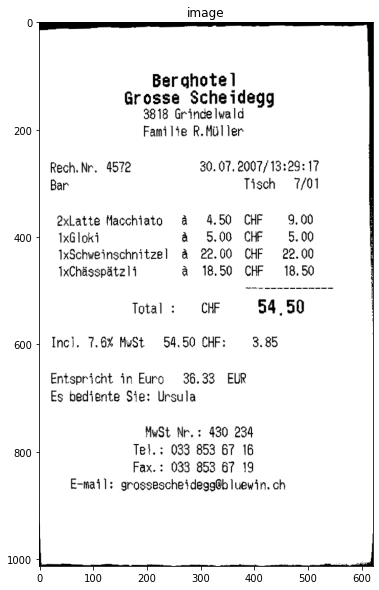

40274.5


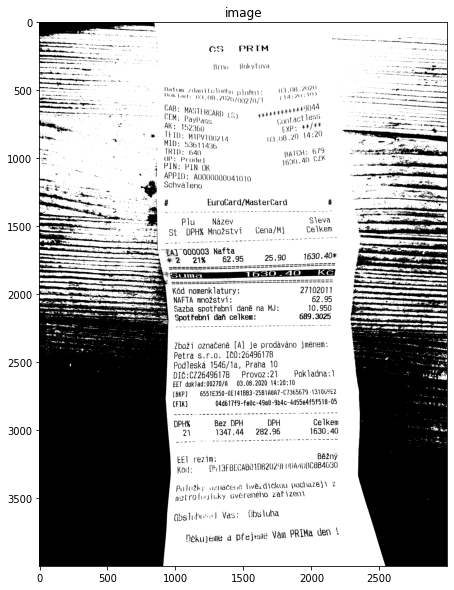

50934.0


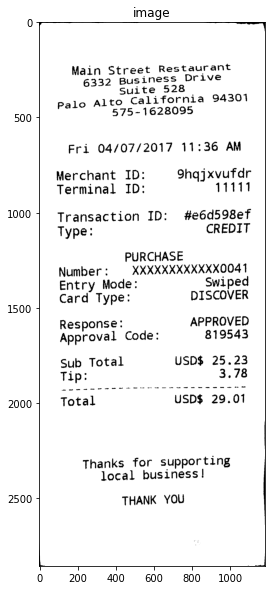

In [2]:
from matplotlib import pyplot as plt
import operator

def show(image, color=None, title="image"):
    plt.figure(figsize = (10, 10))
    plt.title(title)
    plt.imshow(image, "gray")
    plt.show()

for image_name in ["receipt_clean.png", "receipt_creased.jpeg", "receipt_edges.jpeg",
                  "receipt_hard.jpg", "receipt_large.jpeg"]:
    img = cv2.imread(f"images/{image_name}", cv2.IMREAD_GRAYSCALE)
    img = process_image(img)
    show(img)
